In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import warnings

warnings.filterwarnings(action='ignore', message='Mean of empty slice')

# Dataset
<a href="https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/">Dataset</a>
<p>Descrição das colunas: http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml
<p>O objetivo é criar um modelo para fazer a previsão de chuva no dia seguinte.
<p>A coluna RainTomorrow é a variável alvo. Ela tem o valor 1 se choveu no dia seguinte, ou 0 caso não chovatenha chovido.

In [26]:
data = pd.read_csv('weatherAUS.csv')
print('Shape do dataset:',data.shape)
data.Date = pd.to_datetime(data.Date)
data.RainToday = data.RainToday.replace({'No':0, 'Yes':1})
data.RainTomorrow = data.RainTomorrow.replace({'No':0, 'Yes':1})
target = 'RainTomorrow'

Shape do dataset: (145460, 23)


# Duvidas
## Tem 4 colunas com muita informação faltando.
<p>Eu deveria desconsiderar elas logo de inicio? Subtituir quase 50% das linhas faltando pela mediana não iria criar muitos dados irreais?
<p>Para a análise exploratória eu removi todas as linhas que tinham valores faltando (em qualquer coluna) para evitar inserir dados artificiais. É errado fazer isso?

In [27]:
miss = data.isna().sum().reset_index()
miss.columns=['Coluna', 'Valores faltando']
miss['%'] = 100 * (miss['Valores faltando'] / len(data))
miss.sort_values(by='Valores faltando', ascending=False)

,Coluna,Valores faltando,%
6,Sunshine,69835,48.009762
5,Evaporation,62790,43.166506
18,Cloud3pm,59358,40.807095
17,Cloud9am,55888,38.421559
15,Pressure9am,15065,10.356799
16,Pressure3pm,15028,10.331363
9,WindDir9am,10566,7.263853
7,WindGustDir,10326,7.098859
8,WindGustSpeed,10263,7.055548
14,Humidity3pm,4507,3.098446


In [28]:
print('Shape após remoção dos valores faltantes:',data.dropna().shape)

Shape após remoção dos valores faltantes: (56420, 23)


## Distribuição incomum
<p>A coluna Rainfall parece estar relacionada a coluna alvo (RainTomorrow), só que ela tem uma distribuição bem incomum. Até o terceiro IQR, todos os valores são 0, enquanto os outliers são os valores relevantes. 
<p><b>É necessário um tratamento adicional pra esse tipo de caso além de reescalar os valores?</b>
<p>No fim eu utilizei RobustScaler do sklearn para todas as colunas numericas. Boa parte delas apresentam varios outliers também.
<p>Não sei se normalmente seria ideal simplesmente remover os outliers, mas nesse caso, chuva costuma estar ligada a condições atípicas do clima, que são representadas justamente por outliers.

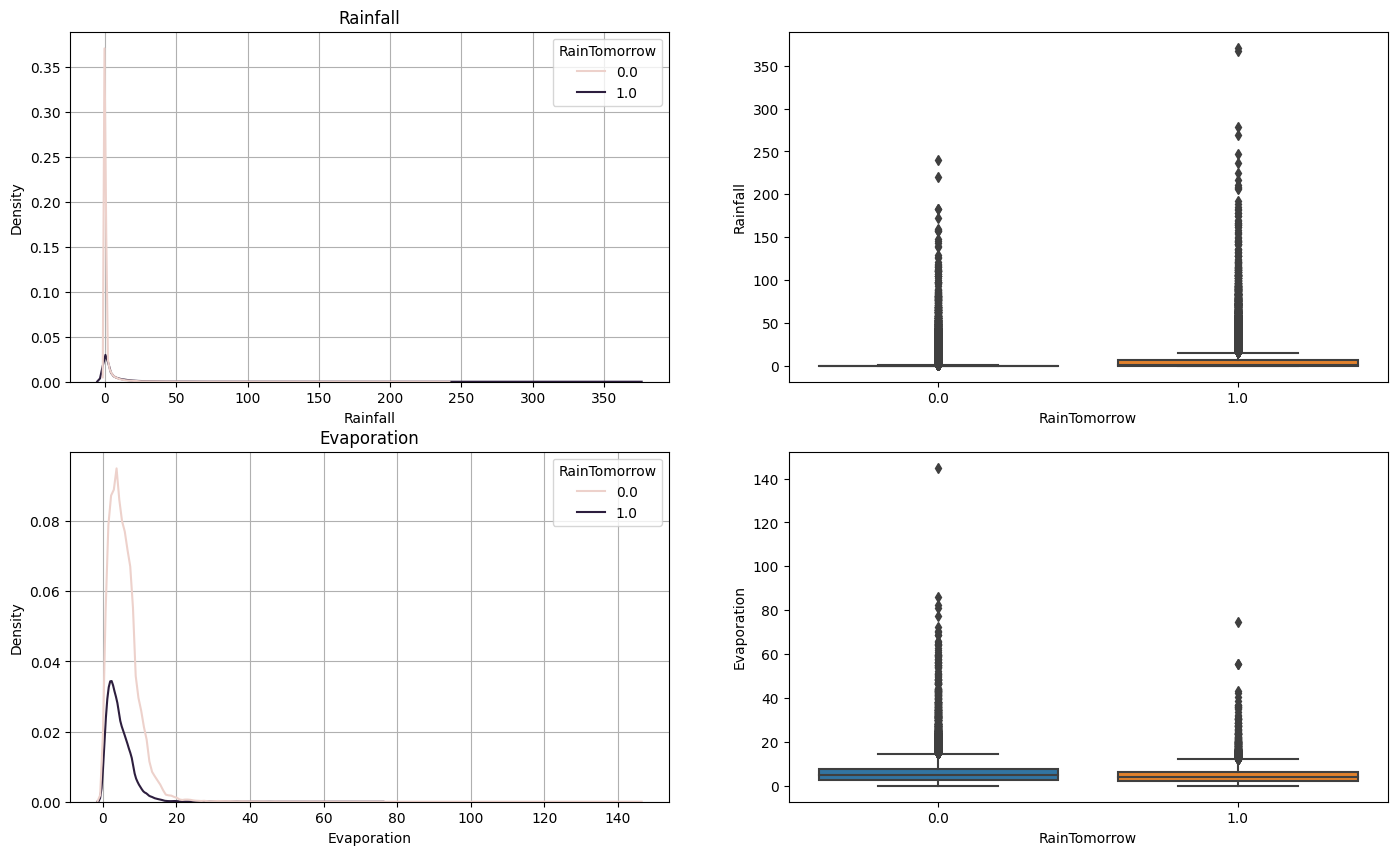

In [29]:
continuous_features = data.select_dtypes('float64').columns.to_list()
n_cols = len(continuous_features)
fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(17, 10))
for i, col in enumerate(['Rainfall', 'Evaporation']):
    ax = axs[i, 0]
    sns.kdeplot(data=data[[col, 'RainTomorrow']], x=col, hue='RainTomorrow', ax=ax)
    ax.set_title(col)
    ax.grid(visible=True)

    ax = axs[i, 1]
    sns.boxplot(data=data[[col, target]], x=target, y=col, ax=ax)


## Medidas de correlação
<p>A medida de correlação padrão do metodo corr() do Pandas é chamada de Pearson, e, pelo que eu li, ela é recomendada para verificar se duas variaveis continuas e com uma distribuição normal tem uma relação linear. Nesse caso, a variável alvo é binaria. Além disso, Pearson é sensivel a outliers.
<p>No fim, utilizei a correlação de Spearman para verificar relação entre as features numéricas, e PointBiserial para verificar a relação entre as features numéricas e a variável alvo, que é binária.
<p>Para as variáveis categoricas usei Cramer's V para determinar se havia relação entre elas e a variável alvo (considerando que variáveis binárias são consideradas categoricas).
<p><b>Essa abordagem está correta? Ou existem alternativas melhores?</b>
<p>Na tabela abaixo eu comparo os valores de correlação entre as variáveis numéricas e a variavel alvo, RainTomorrow. Como eu falei, eu entendi que PointBiserial seria a abordagem correta nesse caso, enquanto a Pearson não, porém as duas apresentam praticamente os mesmos valores, enquanto que Spearman, que eu entendi ser melhor que Pearson em casos com outliers, teve valores diferentes com algumas colunas, o que me deixou ainda mais confuso, não apenas em relação a se escolhi as abordagens corretas, mas se realmente faz diferença entre escolher o teste de correlação correto pra cada caso ou simplesmente usar Pearson.

In [30]:
data.dropna(inplace=True)
corr_df = []
cols = data.select_dtypes('float64').columns.to_list()
for col in cols:
    corr_df.append(pointbiserialr(data.RainTomorrow, data[col]).correlation)

tab_correlations = pd.DataFrame(zip(cols, corr_df), columns=['Feature', 'PointBiserial'])
corr_pearson = pd.DataFrame(data[cols].corrwith(data[target], method='pearson')).reset_index()
corr_pearson.columns=['Col', 'Pearson']
corr_spearman = pd.DataFrame(data[cols].corrwith(data[target], method='spearman')).reset_index()
corr_spearman.columns=['Col', 'Spearman']
tab_correlations = pd.concat([tab_correlations, corr_pearson.Pearson, corr_spearman.Spearman], axis=1)
tab_correlations

,Feature,PointBiserial,Pearson,Spearman
0,MinTemp,0.087428,0.087428,0.077983
1,MaxTemp,-0.147467,-0.147467,-0.143724
2,Rainfall,0.254342,0.254342,0.333034
3,Evaporation,-0.130002,-0.130002,-0.138866
4,Sunshine,-0.453407,-0.453407,-0.438224
5,WindGustSpeed,0.233158,0.233158,0.211631
6,WindSpeed9am,0.083904,0.083904,0.075010
7,WindSpeed3pm,0.088862,0.088862,0.077175
8,Humidity9am,0.271033,0.271033,0.282573
9,Humidity3pm,0.455358,0.455358,0.439041


<p>As colunas Temp9am (temperatura medida as 9 da manha), Temp3pm (temperatura medida as 3 da tarde), MaxTemp (temperatura máxima registrada no dia) e MinTemp (temperatura mínima registrada no dia) tinham uma correlação grande entre si. Temp3pm e MaxTemp tinham correlação de 0.99. Eu li sobre Multicolinearity e que ela não é algo positivo para modelos de regressão (por mais que eu não saiba explicar muito bem o porque). 
<p><b>Nesse caso, realmente é importante remover algumas delas ou não?</b> Encontrei opiniões diferentes sobre o assunto.

## Feature Engineering

<p>Tentei criar algumas features novas também baseado no que eu li sobre o assunto. Criei 3 derivadas da coluna Date: season(1 a 4 representando a estação do ano), wet_season (boolean indicando se estava na estação de chuvas da australia) e month.
<p>Chuvas costumam alterar humidade, direção/velocidade do vento e temperatura, então criei algumas features com isso em mente:
<ul>
<li>DiffEvaporationFromPrevDay: Diferença entre evaporação do dia atual e do anterior.
<li>DiffHumidityFromPrevDay3pm: Diferença entre humidade as 3 da tarde do dia atual e do anterior.
<li>DiffHumidityFromPrevDay9am: Diferença entre humidade as 9 da manhã do dia atual e do anterior.
<li>VarHumiditySameDay: diferença entre humidade as 3 da tarde e 9 da manhã do mesmo dia.
<li>DiffStrongestWindToTheDayAvg: diferença entre a velocidade do vento mais forte do dia e a media entre a velocidade do vento as 9am e 3pm.
</ul>

<p>A temperatura e humidade são relacionados a localização geografica da cidade, então também criei features baseadas na média apenas da cidade. Ex:
<ul>
  <li>VarFromLocalHumidity9am: Diferença entre a humidade as 9 da manhã e a média de humidade as 9 da manhã referente somente à cidade em questão.
</ul>
Criei 6 features seguindo essa mesma lógica.

<p>A feature VarFromLocalHumidity3pm por exemplo apresentou uma correlação (PointBiserial) com a variável alvo de 0.42, o que é mais do que as outras variaveis que não costumam passar de 0.3. Porém a variável original (Humidity3pm) tem um valor de correlação próximo, então não sei se a feature que eu criei contribui para resolver o problema ou se ela apenas insere informação repetida. Eu verifiquei a correlação entre as variáveis derivadas e as originais para averiguar se elas tinham correlação linear, o que eu imagino que indicaria se elas são apenas informação repetida (voltando ao problema de Multicolinearity), mas nenhuma tinha correlação linear forte.
<p>Minhas duvidas:
<ul>
<li><b>Faz sentido criar features dessa maneira? Ou tem algum processo mais estruturado? Eu não encontrei muito quando pesquisei sobre isso.</>
<li><b>Estou correto em presumir que correlação entre uma feature derivada e a original indica se uma feature nova apenas insere informação repetida?</>
</>

<p>Também tentei criar uma feature chamada WindDirChange baseada na direção do vento, que é uma variavel categorica. Nesse caso apenas concatenei as duas strings juntas como mostro na tabela abaixo. Além disso, as duas colunas originais não posuiam uma correlação relevante com a variável alvo. A correlação (Cramer) da feature que eu criei com a coluna alvo é maior do que as originais, mas ainda não é um valor relevante (0.19 da coluna nova comparado com 0.13 e 0.11 das originais).
<ul>
<li><b>Vale a pena derivar outas features de colunas que aparentemente não são tão 
relevantes?</b>
<li><b>Faz sentido criar features categoricas dessa maneira?</b>
</ul>


In [31]:
data['WindDirChange'] = data.WindDir9am + '>' + data.WindDir3pm
data[['WindDir9am', 'WindDir3pm', 'WindDirChange']].head(5)

,WindDir9am,WindDir3pm,WindDirChange
6049,ENE,SW,ENE>SW
6050,SSE,SSE,SSE>SSE
6052,NNE,NNW,NNE>NNW
6053,WNW,WSW,WNW>WSW
6054,NW,WNW,NW>WNW


## Escolha do modelo
<p>Para selecionar o algoritmo, eu coloquei varios modelos numa lista, comparei a média dos scores resultantes do método cross_val_score do sklearn e escolhi o modelo com a melhor média. O resultado está no print abaixo.
<p><b>Essa é uma boa maneira de selecionar qual algoritmo usar?</b>

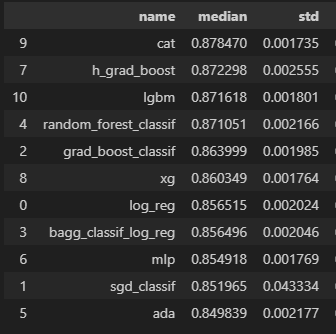

# Resultados
<p>Depois de todo esse processo, o restultado não parece ter melhorado. Apenas treinar o CatBoostClassifier com os valores numéricos tem um resultado similar em relação ao modelo que utiliza as variáveis criadas no processo de Feature Engineering.

In [32]:
def make_report(model, X_train_, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(6,4))
    plt.plot(fpr,tpr,'-g',linewidth=1)
    plt.plot([0,1], [0,1], 'k--' )
    plt.title('ROC curve')
    plt.xlabel("False Positive Rate")
    plt.ylabel('True Positive Rate')
    plt.show()

## CatBoost apenas com os valores originais

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     36466
           1       0.74      0.54      0.62     10458

    accuracy                           0.86     46924
   macro avg       0.81      0.74      0.77     46924
weighted avg       0.85      0.86      0.85     46924



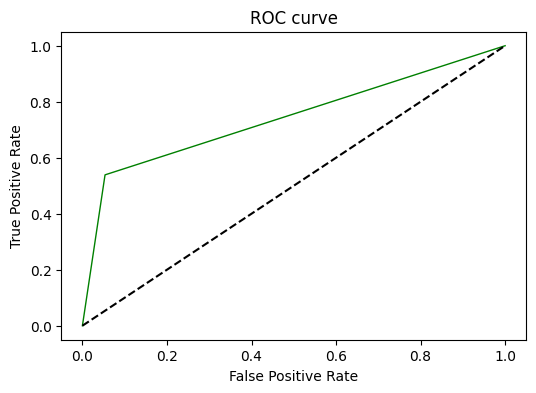

In [33]:
data_og = pd.read_csv('weatherAUS.csv')
data_og.dropna(subset=['RainTomorrow'], inplace=True)
data_og.RainToday = data_og.RainToday.replace({'No':0, 'Yes':1})
data_og.RainTomorrow = data_og.RainTomorrow.replace({'No':0, 'Yes':1})
X_train, X_test, y_train, y_test = train_test_split(data_og.select_dtypes('number').drop('RainTomorrow', axis=1), data_og.RainTomorrow, test_size=0.33, random_state=42)
#pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
#                    ('scaler', RobustScaler()),
#                       ('cat', CatBoostClassifier(verbose=False))])
clf = CatBoostClassifier(verbose=False)
clf.fit(X_train, y_train)
make_report(clf, X_train, y_train, X_test, y_test)

## CatBoost após Feature Engineering

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     36466
           1       0.75      0.54      0.63     10458

    accuracy                           0.86     46924
   macro avg       0.81      0.74      0.77     46924
weighted avg       0.85      0.86      0.85     46924



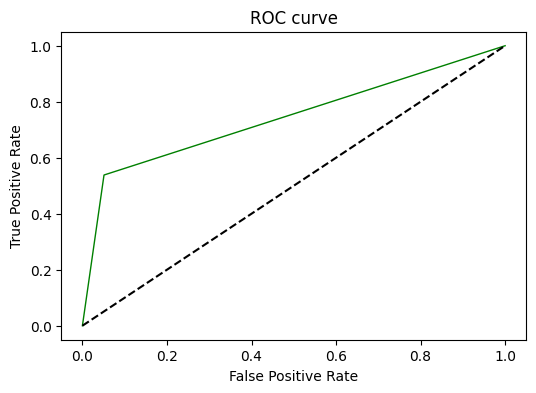

In [34]:
data_fe = pd.read_csv('weatherAUS.csv')
data_fe.dropna(subset=['RainTomorrow'], inplace=True)
data_fe.drop('Date', axis=1, inplace=True)
data_fe.drop(['Evaporation', 'Sunshine'], axis=1, inplace=True)
data_fe.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1, inplace=True)

data_fe.RainToday = data_fe.RainToday.replace({'No':0, 'Yes':1})
data_fe.RainTomorrow = data_fe.RainTomorrow.replace({'No':0, 'Yes':1})

data_fe['DiffHumidityFromPrevDay3pm'] = data_fe.Humidity3pm.diff(1)
data_fe['DiffHumidityFromPrevDay9am'] = data_fe.Humidity9am.diff(1)
data_fe['VarHumiditySameDay'] =  data_fe.Humidity3pm - data_fe.Humidity9am
data_fe['DiffStrongestWindToTheDayAvg'] = data_fe.WindGustSpeed - ((data_fe.WindSpeed3pm + data_fe.WindSpeed9am)/2)

medians_humidity_9am = {}
medians_humidity_3pm = {}
medians_cloud_9am = {}
medians_cloud_3pm = {}
for location in data_fe.Location.unique().tolist():
    medians_humidity_9am[location] = data_fe[data_fe.Location == location].Humidity9am.median()
    medians_humidity_3pm[location] = data_fe[data_fe.Location == location].Humidity3pm.median()
    medians_cloud_9am[location] = data_fe[data_fe.Location == location].Cloud9am.median()
    medians_cloud_3pm[location] = data_fe[data_fe.Location == location].Cloud3pm.median()

data_fe['VarFromLocalCloud9am'] = data_fe.apply(
    lambda row : row.Cloud9am - medians_cloud_9am[row.Location], axis=1)

data_fe['VarFromLocalCloud3pm'] = data_fe.apply(
    lambda row : row.Cloud3pm - medians_cloud_3pm[row.Location], axis=1)

data_fe['VarFromLocalHumidity9am'] = data_fe.apply(
    lambda row : row.Humidity9am - medians_humidity_9am[row.Location], axis=1)

data_fe['VarFromLocalHumidity3pm'] = data_fe.apply(
    lambda row : row.Humidity3pm - medians_humidity_3pm[row.Location], axis=1)

data_fe.drop('Location', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_fe.select_dtypes('number').drop('RainTomorrow', axis=1), data_fe.RainTomorrow, test_size=0.33, random_state=42)
pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                    ('scaler', RobustScaler()),
                       ('cat', CatBoostClassifier(verbose=False))])

pipe.fit(X_train, y_train)
make_report(pipe, X_train, y_train, X_test, y_test)

<p><b>Esses resultados indicam que o processo de Feature Engineeing não foi feito corretamente?</b> Ou não havia muito o que melhorar, considerando que as features originais não tem uma correlação muito alta com a variável alvo? Eu ainda estou tentando tunar os parâmetros do modelo, mas não creio que va fazer uma diferença muito grande.
<p><b>Esses resultados são aceitáveis para um projeto? Como entrevistador de candidatos, o que o senhor pensaria sobre esses resultados?</b> Eu gostaria de colocar esse projeto como portfólio, assim que eu conseguir finaliza-lo.

## Dataset desbalanceado

<p>O dataset é extremamente desbalanceado. Os valores de Recall em torno de 0.54 provavelmente são resultado disso. Então tentei também Upsampling e Downsampling, porém a precisão quando a previsão é 1 (1 significa que choveu no outro dia) fica ainda pior.

[Text(0, 0, '78%'), Text(0, 0, '22%')]

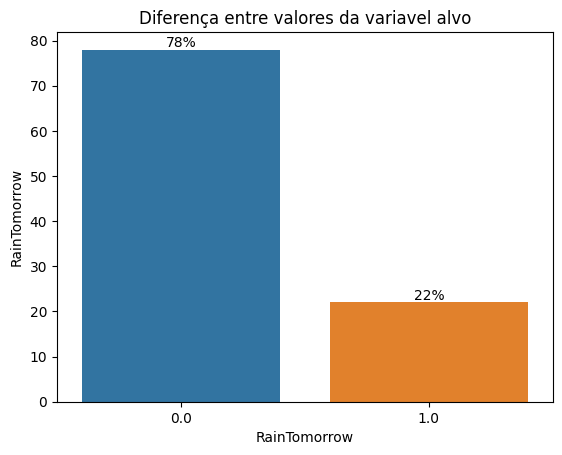

In [35]:
ax = sns.barplot(x=data.RainTomorrow, y = data.RainTomorrow, estimator=lambda x : len(x)/len(data) * 100)
ax.set_title('Diferença entre valores da variavel alvo')
ax.bar_label(ax.containers[0], fmt='%.f%%')

## Upsampling
<p>Com CatBoost, Upsampling não fez muita diferença, porém com outros modelos que testei, a precisão diminuia mas o recall da variável com menor quantidade aumentava.

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     36466
           1       0.73      0.55      0.63     10458

    accuracy                           0.85     46924
   macro avg       0.80      0.75      0.77     46924
weighted avg       0.85      0.85      0.85     46924



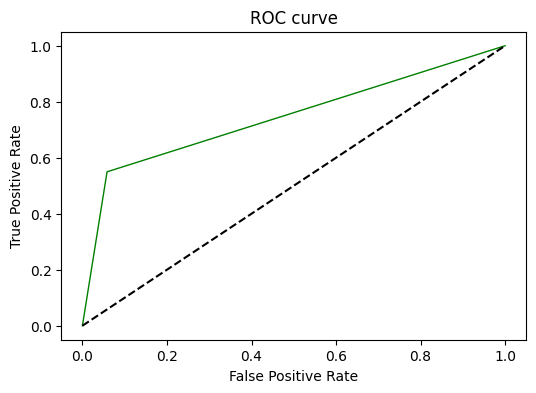

In [36]:
data_og = pd.read_csv('weatherAUS.csv')
data_og.dropna(subset=['RainTomorrow'], inplace=True)
data_og.RainToday = data_og.RainToday.replace({'No':0, 'Yes':1})
data_og.RainTomorrow = data_og.RainTomorrow.replace({'No':0, 'Yes':1})
X_train, X_test, y_train, y_test = train_test_split(data_og.select_dtypes('number').drop('RainTomorrow', axis=1), data_og.RainTomorrow, test_size=0.33, random_state=42)
pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                    ('scaler', RobustScaler()),
                    ('upsampling', SMOTE()),
                       ('cat', CatBoostClassifier(verbose=False))])

pipe.fit(X_train, y_train)
make_report(pipe, X_train, y_train, X_test, y_test)

## Undersampling
<p>Mesmo resultado do Upsampling com outos modelos. Precisão tem uma queda brusca em troca de um recall maior.

              precision    recall  f1-score   support

           0       0.93      0.81      0.86     36466
           1       0.54      0.78      0.64     10458

    accuracy                           0.80     46924
   macro avg       0.73      0.79      0.75     46924
weighted avg       0.84      0.80      0.81     46924



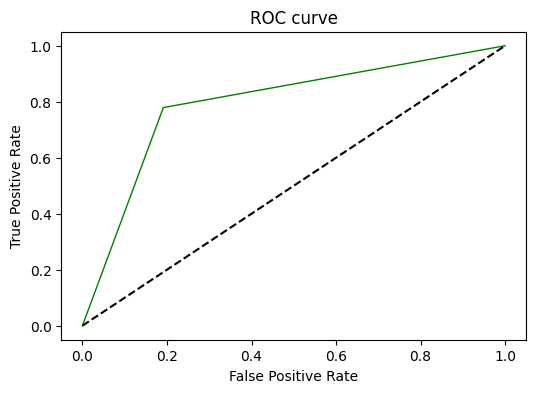

In [37]:
data_og = pd.read_csv('weatherAUS.csv')
data_og.dropna(subset=['RainTomorrow'], inplace=True)
data_og.RainToday = data_og.RainToday.replace({'No':0, 'Yes':1})
data_og.RainTomorrow = data_og.RainTomorrow.replace({'No':0, 'Yes':1})
X_train, X_test, y_train, y_test = train_test_split(data_og.select_dtypes('number').drop('RainTomorrow', axis=1), data_og.RainTomorrow, test_size=0.33, random_state=42)
pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                    ('scaler', RobustScaler()),
                    ('downsampling', RandomUnderSampler()),
                       ('cat', CatBoostClassifier(verbose=False))])

pipe.fit(X_train, y_train)
make_report(pipe, X_train, y_train, X_test, y_test)

<p><b>Realmente não tem como contornar o problema do baixo recall nesse caso?</b>
<p><b>Além disso, devo considerar a acurácia de 86% como um bom resultado, sabendo que ela está sendo inflacionada pela quantidade de dias que não choveu?</b> Afinal, se o modelo sempre chutasse que não vai chover, ele ainda acertaria 76% das vezes, e o objetivo do modelo é a previsão de chuva.